Mixture Models
===

In [1]:
%matplotlib inline

import numpy as np
from scipy import linalg
from sklearn import mixture
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import time
import sys
from IPython.display import display, clear_output
import time
from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

#Plot the clustering
def plot_clusters(ax,labels, means, covars, X,i):
  
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    for k, col in zip(unique_labels, colors):
        col = mpl.colors.rgb2hex(col[:3])
        class_member_mask = (labels == k)
        xy = X[class_member_mask]
        ax.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=5, alpha=0.5)

    ax.set_title('Clustering: Iteration %d'%(i))  

#Plot the clustering
def plot_cluster_comps(ax,labels, means, covars, X,i):
  
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    
    ax.plot(X[:,0],X[:,1],'k.',alpha=0.5,markersize=1)
    
    for k, col in zip(unique_labels, colors):

        v, w = linalg.eigh(covars[k,:,:])
        u = w[0] / linalg.norm(w[0])
        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        ell1 = mpl.patches.Ellipse(means[k,:], 2*np.sqrt(v[0]), 2*np.sqrt(v[1]), 180 + angle, color=col)
        ell1.set_alpha(0.8)
        ell2 = mpl.patches.Ellipse(means[k,:], 2*np.sqrt(v[0]), 2*np.sqrt(v[1]), 180 + angle, fill=False, color=col)
        ell2.set_alpha(1)

        ax.add_artist(ell1)
        ax.add_artist(ell2)

    ax.set_title('Clustering: Iteration %d'%(i)) 

def plot_density(ax,xdims,ydims,pdf,title):
    
    #Prepare grid for plotting decision surface
    gx1, gx2 = np.meshgrid(np.arange(xdims[0], xdims[1],(xdims[1]-xdims[0])/100.0 ),
                           np.arange(ydims[0], ydims[1],(ydims[1]-ydims[0])/100.0 ),)
    gx1l = gx1.flatten()
    gx2l = gx2.flatten()
    gx   = np.vstack((gx1l,gx2l)).T

    #Compute a prediction for every point in the grid
    #Cache for fast redisplay
    y = np.exp(pdf.score_samples(gx))
    y = np.reshape(y,gx1.shape)
    
    ax.imshow(y, interpolation='nearest',
               extent=(xdims[0], xdims[1],ydims[0], ydims[1]), aspect='auto',
               origin='lower', cmap=plt.cm.coolwarm, alpha=1)
                     
    ax.set_xlabel('x1');
    ax.set_ylabel('x2');
    ax.grid(True)
    ax.set_title(title);

Generate Data
---

In [2]:
datasets={}

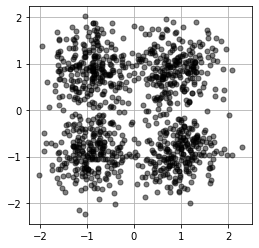

In [3]:
#Set cluster compactness
std=0.5
n_samples=1000

# Generate cluster data
centers = [[1, 1], [-1, -1], [1, -1],[-1,1]]
X, labels_true = make_blobs(n_samples=1000, centers=centers, cluster_std=std,random_state=0)
X = StandardScaler().fit_transform(X)

datasets["Blobs"]=X

plt.figure(figsize=[4,4])
plt.plot(X[:, 0], X[:, 1], 'ko', markersize=5, alpha=0.5);
plt.grid(True)
plt.show()

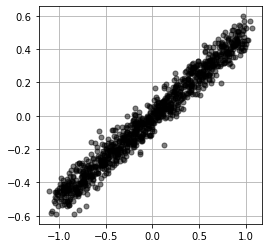

In [4]:
#Generate manifold data
n_samples=1000
std    = 0.05
theta  = 2*np.pi*np.random.rand(n_samples)
X      = np.zeros((n_samples,2)) 
X[:,0] = 2*np.random.rand(n_samples)-1
X[:,1] = 0.5*X[:,0]
X      = X + std*np.random.randn(n_samples,2)

datasets["Linear"]=X

plt.figure(figsize=[4,4])
plt.plot(X[:, 0], X[:, 1], 'ko', markersize=5, alpha=0.5);
plt.grid(True)
plt.show()

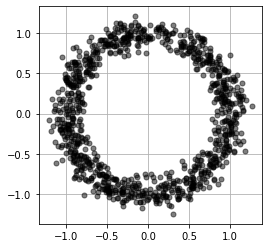

In [5]:
#Generate manifold data
n_samples=1000
std=0.1
r      = 1 
theta  = 2*np.pi*np.random.rand(n_samples)
X      = np.zeros((n_samples,2)) 
X[:,0] = np.cos(theta)
X[:,1] = np.sin(theta)
X      = X + std*np.random.randn(n_samples,2)

datasets["Circular"]=X

plt.figure(figsize=[4,4])
plt.plot(X[:, 0], X[:, 1], 'ko', markersize=5, alpha=0.5);
plt.grid(True)
plt.show()

Define Gaussian Mixture Model
---

In [10]:

def run_gmm(K=20, dataset=[],steps=50 , out=[]):

    global stop
    
    X = dataset

    n_clusters=K #Set Number of Clusters
    L=steps # Number of learning steps
    cost = np.zeros(L) #Custering cost

    #Randomly Initialize the Clusters
    ind = np.random.permutation(X.shape[0])

    centers = X[ind[:n_clusters],:] 
    clf = mixture.GaussianMixture(n_components=n_clusters, means_init=centers, covariance_type='diag', n_init=1, init_params="random", max_iter=1,warm_start=True)
    clf.fit(X)

    with out:

        for i in range(L):

            fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(8,6))
            fig.tight_layout()

            means = clf.means_
            cov_vecs = clf.covariances_
            
            covars = np.zeros([K,2,2])
            for k in range(K):
                covars[k,:,:] = np.diag(cov_vecs[k,:])
            
            labels = clf.predict(X)
            cost[i] = -np.sum(clf.score(X))
            clf.fit(X)

            plot_clusters(ax1,labels, means, covars,X,i)

            plot_cluster_comps(ax2,labels, means, covars,X,i)

            plot_density(ax3,[-1.5,1.5],[-1.5,1.5],clf,"Density")

            ax4.plot(cost[:i+1],'b-')
            ax4.set_xlim(0,max(100,i))
            ax4.set_ylim(min(0,1.05*min(cost[:i+1])),1.05*max(cost[:i+1]))
            ax4.set_title("Cost: Iter %d"%(i))
            ax4.grid(True)

            clear_output(wait=True)
            plt.show()

            time.sleep(0.01)
            if(stop): break

    

In [11]:
import ipywidgets as widgets
import threading

stop=False

rbutton = widgets.Button(description='Run')
sbutton = widgets.Button(description='Stop')

kslider = widgets.IntSlider(
    value=1,
    min=1,
    max=25,
    step=1,
    description='K:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

data_drop = widgets.Dropdown(
    options=list(datasets.keys()),
    value=list(datasets.keys())[0],
    description='Dataset:',
    disabled=False,
)

out = widgets.Output()

worker = []

def on_rbutton_clicked(_):
    global worker
    global stop
    stop = False
    #worker=threading.Thread(target=run_gmm, kwargs={"K":kslider.value, "dataset":datasets[data_drop.value],"out":out})
    #worker.start()
    run_gmm(K=kslider.value, dataset = datasets[data_drop.value],out=out, steps=50)

def on_sbutton_clicked(_):
    global stop
    global worker
    stop = True
    #worker.join()
        
rbutton.on_click(on_rbutton_clicked)
sbutton.on_click(on_sbutton_clicked)

widgets.VBox([widgets.HBox([kslider, data_drop,rbutton]),out])
